# ANLP 2021 - Assignment 3

Yerkezhan Abdullayeva, (enter your name/student id number here)

<div class="alert alert-block alert-danger">Due: Monday, January 17, 2022, 23:59</div>

<div class="alert alert-block alert-info">

**NOTE**
<br>

Please first fill in your name and id number at the top of the assignment, and **rename** the assignment file to **yourlastname-anlp-3.ipynb**<br><br>
Problems and questions are given in blue boxes like this one. All grey and white boxes marked by the comment "#student solution/discussion here" must be filled by you (they either require code or a (brief!) discussion). <br><br>
Please hand in your assignment by the deadline via Moodle. In case of questions, you can contact the TAs and the instructors via the usual channels.

</div>

<div class="alert alert-block alert-info">
    
In this assignment, you will implement an LSTM model and train it to generate text, one character at a time. (So note: We're asking you to create a character-level model; in the lectures, we've so far only seen word-level models. Think about what the difference is, and what its practical consequences are.)

For training, we prepared two text files (train and test) containing passages from Charles Dickens' novels (dickens_train.txt, dickens_test.txt).

You should use the PyTorch machine learning library to implement this exercise.

- Instructions to install PyTorch can be found here: <http://pytorch.org/>
- The introductory tutorial we prepared for PyTorch is attached to the assignment: pytorch_tutorial.ipynb
- Some PyTorch examples for an in depth overview: <https://github.com/jcjohnson/pytorch-examples>
- Another common quickstart tutorial is this [PyTorch 60 Minutes Blitz](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html)

(But don't get carried away: For this assignment, you mostly need the very straightforward elements from the `nn` module in PyTorch that implement the layers that you've learned about, such as RNNS, LSTMs, embeddings.)

This assignment is designed to be runnable on a decent CPU. With a 2-layer LSTM and hidden size of 128, it takes ~20 minutes to train while with hidden size of 512, it takes ~2 hours. Please take this into consideration while doing this assignment. 

Alternatively you can also use Google Colab <https://colab.research.google.com/> by uploading your notebook there, which gives you access to a GPU. (Check that you are indeed using the GPU, via `print(torch.cuda.is_available()`.) However, please keep mind as there is limitation for the free edition (i.e. 'maximum lifetime' of 12 hours).


The goal of this assignment is to get you to specify a simple network, and play around with its hyperparameters to explore how they affect the output. This is why we're providing you with a lot of code, to ensure that the basic housekeeping is taken care of.

</div>

# Prepare data

The file we are using is a plain text file. We turn any potential unicode characters into plain ASCII by using the `unidecode` package (which you can install via `pip` or `conda`). (What do you think is the use of this step?)

In [2]:
! pip install unidecode
#I dont know why but in google collab I always have to redownload unicode

     |████████████████████████████████| 235 kB 5.1 MB/s 


In [5]:
import unidecode
import string
import random
import re

all_characters = string.printable
n_characters = len(all_characters)

file = unidecode.unidecode(open('dickens_train.txt').read())
file_len = len(file)
print('file_len =', file_len)

file_len = 1136673


To make inputs out of this big string of data, we will be splitting it into chunks.

In [6]:
chunk_len = 200

def random_chunk():
    start_index = random.randint(0, file_len - chunk_len -1) 
    end_index = start_index + chunk_len + 1
    return file[start_index:end_index]

print(random_chunk())

y precious!" and "my bird!" and spreading
her golden hair aside over her shoulders with great pride and care.

  "And you in brown!" she said, indignantly turning to Mr. Lorry;
"couldn't you tell her w


# Build the Model (30 points)

<div class="alert alert-block alert-info">

The model that you are asked to build will take as input characters up to step $t-1$ and is expected to produce a distribution over characters at step $t$ (which can then be used to sample one character from that distribution). 

There are three layers: one layer that maps the input character into its embedding, one LSTM layer (which may itself have multiple layers) that operates on that embedding and a hidden and cell state, and a decoder layer that outputs the probability distribution.

The beauty of frameworks such as PyTorch is that you can express this pretty directly in code, adding (pre-defined) layers to your network.
</div>

In [7]:
#student solution/discussion here

import torch
import torch.nn as nn
#you can import additional libraries if needed.

# Here is a pseudocode to help with your LSTM implementation. 
# You can add new methods and/or change the signature (i.e., the input parameters) of the methods.
class LSTM(nn.Module):
    def __init__(self, dimension_input, dimention_hidden, output_size, layers_size,emb_dim = 100):
        super(LSTM, self).__init__()
        self.dimension_input = dimension_input
        self.layers_size = layers_size
        self.dimention_hidden = dimention_hidden
        self.output_size = output_size
        self.batch_size = 1
        self.EMBD = nn.Embedding(dimension_input, dimention_hidden)
        #100 is the size of each embedding vector
        self.lstm = nn.LSTM(dimention_hidden, dimention_hidden, layers_size, batch_first = True)
         #This is our recurrence layer-it is our decoder and it grasps  the layer of embedded charcater numbers like number of charachters(inputs) and outputs of hidden state
        #from the training part:decoder = LSTM(n_characters, dimention_hidden, n_characters, n_layers).
        self.linear_layer = nn.Linear(dimention_hidden, output_size)
        #This is linear layer. 

    
    def forward(self, x,hidden_lay):
        embedding = self.EMBD(x) 
        result1, (self.hidden_zeros, self.cell_zeros) = self.lstm(embedding.view(1, 1, -1), hidden_lay) 
        result2 = self.linear_layer(result1.view(1, -1)) 
        #here we will get output of the linear layer
        return result2, (self.hidden_zeros, self.cell_zeros)
        

    def init_hidden(self):   
        #we have already assigned 1 to batch size above
        #creating tensors
        
        self.hidden_zeros = torch.zeros((self.layers_size, self.batch_size, self.dimention_hidden))
        self.cell_zeros = torch.zeros((self.layers_size, self.batch_size, self.dimention_hidden)) 
        return self.hidden_zeros, self.cell_zeros

# Inputs and Targets

Each chunk of the training data needs to be turned into a sequence of numbers (of the lookups), specifically a `LongTensor` (used for integer values). This is done by looping through the characters of the string and looking up the index of each character in `all_characters`.

In [8]:
from torch.autograd import Variable 

# Turn string into list of longs
def char_tensor(string):
    tensor = torch.zeros(len(string)).long()
    for c in range(len(string)):
        tensor[c] = all_characters.index(string[c])
    return Variable(tensor)

print(char_tensor('abcDEF'))

tensor([10, 11, 12, 39, 40, 41])


Finally we can assemble a pair of input and target tensors for training, from a random chunk. The inputs will be all characters *up to the last*, and the targets will be all characters *from the first*. So if our chunk is "abc" the inputs will correspond to "ab" while the targets are "bc".

In [9]:
def random_training_set():    
    chunk = random_chunk()
    inp = char_tensor(chunk[:-1])
    target = char_tensor(chunk[1:])
    return inp, target

Play around with these functions to understand what they do.

# Generating

We also provide a generator function that shows you how you can sample from your model (and how we expect the interface to work). 

`decoder` is your model that is passed into the function. To start generating, we pass a priming string to start building up the hidden state, from which we then generate one character at a time. To generate strings with the network, we will feed one character at a time, use the outputs of the network as a probability distribution for the next character, and repeat. 

In [10]:
def generate(decoder, prime_str='A', predict_len=100, temperature=0.8):
    hidden, cell = decoder.init_hidden()
    prime_input = char_tensor(prime_str)
    predicted = prime_str

    # Use priming string to "build up" hidden state
    for p in range(len(prime_str) - 1):
        _, (hidden, cell) = decoder(prime_input[p], (hidden, cell)) 
    inp = prime_input[-1]
    
    for p in range(predict_len):
        output, (hidden, cell) = decoder(inp, (hidden, cell))
        
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]
        
        # Add predicted character to string and use as next input
        predicted_char = all_characters[top_i]
        predicted += predicted_char
        inp = char_tensor(predicted_char)

    return predicted

# Training

A helper to print the amount of time passed:

In [11]:
import time, math

def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

The main training function

In [12]:
def train(decoder, decoder_optimizer, inp, target):
    hidden, cell = decoder.init_hidden()
    decoder.zero_grad()
    loss = 0

    for c in range(chunk_len):
        output, (hidden, cell) = decoder(inp[c], (hidden, cell))
        loss += criterion(output, target[c].view(1))

    loss.backward()
    decoder_optimizer.step()

    return loss.item() /chunk_len

Then we define the training parameters, instantiate the model, and start training:

In [13]:
n_epochs = 3000
print_every = 100
plot_every = 10
hidden_size = 128
n_layers = 2

lr = 0.005
decoder = LSTM(n_characters, hidden_size, n_characters, n_layers)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
loss_avg = 0

for epoch in range(1, n_epochs+1):
    loss = train(decoder, decoder_optimizer, *random_training_set())
    loss_avg += loss

    if epoch % print_every == 0:
        print('[{} ({} {}%) {:.4f}]'.format(time_since(start), epoch, epoch/n_epochs * 100, loss))
        print(generate(decoder, 'A', 100), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg/ plot_every)
        loss_avg = 0

 21s (100 3.3333333333333335%) 2.4668]
ATo, to rarstiof of ad wosder of I 
ak an gile, 
obit nhoede be the ot
tbar aded
thubk pouved the on  

 44s (200 6.666666666666667%) 2.3689]
At ofut iblot 
lerkend it whoon to her
dessad banai
mey the hik to some the nere med  sean caveellit  

 7s (300 10.0%) 2.4660]
A' what of fad missill.' I I the shich link the ice whivee said so wacand and bever bace or disted if 

 30s (400 13.333333333333334%) 2.3187]
Ad wasped and thir. I 
bewh hissed she in and unted the Hart a he mewtrands me it ampearker here
of s 

 52s (500 16.666666666666664%) 2.0185]
A? Clould the bus bemally seney.  You pritid. Mr, and four shere ondear the pain, boncion apter Hous  

 15s (600 20.0%) 2.0930]
A Mr. reyen and the rooks and abed it
ands a pate and. Mhe 
Rove and that Mr. younted berer.

  That  

 37s (700 23.333333333333332%) 2.0602]
Aver fill calk I been whor willing to of to nower and bone to mong all qut he to had and deely the he 

 59s (800 26.666666666666668%


# ***1.What do these parameters do?***

**n_epochs = 3000: ***
This means how many  times that the algorithm  goes through the dickens_training_data and how many times it will learn.
**print_every = 100:** when the epoch reaches 100 it prints hundreds one by one.For example,200,300.....

**hidden_size = 128:**  How many features we have in the hidden layer

**n_layers = 2:**: the amount of hidden layers in  the LSTM.

**lr = 0.005:**: How big out steps of the learning rate in gradient descent.We use it to find the minumun loss in gradient descent.


# **What is happening inside the training loop?** 
In the loop we have the:

**time**-how long it took to learn for the model,the algorith for it has been written for us,

**every 100th epoch's number**-as I have stated above,the model is printing with a difference of 100 epochs.

**Percentage**-how many percent is already trained.

**Loss**- the result of the loss function

**decoder = LSTM(n_characters, hidden_size, n_characters, n_layers)**-every epoch is being trained by this generation model.

Explain in your words what is going on here. What do these parameters do, what is happening inside the training loop? (**bonus question**)

# Hyperparameter tuning (30 points)

<div class="alert alert-block alert-info">

Building neural networks is to some extent more an art than a science. As we have seen above, there are several hyperparameters (i.e., parameters that are not optimized during learning, but that determine the shape of the network), and their setting influences the performance. In this problem, you're asked to *tune* these hyperparameters (that is, optimize heuristically, rather than using for example stochastic gradient descent). You can try to do this systematically (how?), or just in general explore what changing the parameter does to the performance. (Keep in mind the time it takes to train again for each setting.)

To do so, you need a target. We'll use bits per character (BPC) over the entire the test set `dickens_test.txt`. 
BPC is defined as the empirical estimate of the cross-entropy between the target distribution and the model output in base 2. 

(Hint1: You can adapt the formula for word-level cross-entropy given in your text book (chapter 9) to character-level as $-\frac{1}{T}*\sum_{i=1}^{T}log{_2}{m(x_t)}$ where T is the length of input string and $x_t$ is the true character in input string at location $t$.)

(Hint2: Tune one parameter at a time) 

(Hint3: Keep a log of your experiments for "parameters used --> minimum loss value")

</div>

In [14]:
#To check which hyperparameter are the most suitable lets tranform our training into s function.

def parameters_tuning(hidden_size, n_layers, lr):

    n_epochs = 3000 
    print_every = 100 
    plot_every = 10
    #decoder is your model that is passed into the function.
    decoder = LSTM(n_characters, hidden_size, n_characters, n_layers)
    decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr) 
    criterion = nn.CrossEntropyLoss() 

    start = time.time()
    all_losses = []
    loss_avg = 0
#we just add some returning values,so we can call it later
    for epoch in range(1, n_epochs+1):
        loss = train(decoder, decoder_optimizer, * random_training_set())
        loss_avg += loss

        if epoch % print_every == 0:
            print('[{} ({} {}%) {:.4f}]'.format(time_since(start), epoch, epoch/n_epochs * 100, loss))
            print(generate(decoder, 'A', 100), '\n')

        if epoch % plot_every == 0:
            all_losses.append(loss_avg/ plot_every)
            loss_avg = 0
    
    return decoder, all_losses

In [15]:
file_test = unidecode.unidecode(open('dickens_test.txt').read()) 
test_tensor = char_tensor(file_test)
#Let's see the length of our test data
print('The length of test file is',len(file_test))

The length of test file is 5476


In [16]:
def bits_per_character(decoder, n_characters, goal): 
    
    hidden, cell = decoder.init_hidden()
    decoder.zero_grad()
    b_per_character = 0

    for c in range(len(n_characters)):
        output, (hidden, cell) = decoder(n_characters[c], (hidden, cell))
        softmax = nn.Softmax()
        out = softmax(output)
    
        out = out.detach().numpy()
        out = out.squeeze()
        t = goal[c].view(1).numpy() 
        b_per_character += math.log(out[t[0]],2) 

    return - (b_per_character / len(n_characters))

In [17]:
change_hidden_size = [64, 128, 256, 512]
result_of_chd_hidden_size = []

for hidden_size in change_hidden_size:
    print ('Learning model with hidden size {}, number of layers {}, learning rate {}'.format(hidden_size, 2, 0.005))
    
    trained_model, loss =parameters_tuning(hidden_size, n_layers=2, lr=0.005) 
    print ('Minimal loss ', min(loss))
    
    bits_per_character_result = bits_per_character(trained_model, test_tensor [:-1], test_tensor [1:])
    print ('BPC value ', bits_per_character_result)
    
    result_of_chd_hidden_size.append('Hyperparameters: hidden size {}, number of layers {}, learning rate {}. \n Evaluations: min loss {}, BPC {}'.format(hidden_size, 2, 0.005, min(loss), bits_per_character_result))
#we need it later for out plotting exersize.
result_of_chd_hidden_size.append('\n')

Learning model with hidden size 64, number of layers 2, learning rate 0.005
 17s (100 3.3333333333333335%) 3.3040]
ATteg t.  yd  intg ar tennts, oles hdjim od  
hee 'siiot
b beom ocetet ta 
an an tmalie  hwel lif ols 

 34s (200 6.666666666666667%) 2.7746]
Au
binl' tof an I M.  om kere nerin, po
ked cwis eond lorive sorley mee.  potad she
sar rerhese cangt 

 52s (300 10.0%) 2.4937]
Ashos wreres he the and  at fargtot indeu serous hored om the ar  u wingsed ind 
erey
iny be
tike ko  

 9s (400 13.333333333333334%) 2.4094]
A0f  yows. 'oe sasterser, belmere yours warg? 

fut opeseel yoope ongt ous whanged Pe Mler slle cage  

 27s (500 16.666666666666664%) 2.1796]
As in to bath in the ut lech the mefuine ai fa. shame Xaiky a med fathy in and aning iny as if he a i 

 45s (600 20.0%) 2.0872]
Af will and anch am me.

and cat ou verod she alt
his the the suss.

'fo cto were me, and
the, fouste 

 2s (700 23.333333333333332%) 1.9187]
A

 more I so wiing my and sinttreld hal
the.  I wardy
and

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # Remove the CWD from sys.path while we load stuff.


BPC value  2.68350434152888
Learning model with hidden size 128, number of layers 2, learning rate 0.005
 21s (100 3.3333333333333335%) 2.3759]
A,"
 zals I me
artithimtel.'


kend an Nins; cice oning ing an. sot cof non: with and h. os yon lon c 

 43s (200 6.666666666666667%) 2.1711]
APl ith agy 
lave im shos it Pes shid she 
the she this he sith me nomed his wat, of sto had wherst a 

 6s (300 10.0%) 2.0851]
APrd and reaps one it in his
yout hit
the ind bost shis to Domgs the fare, had by sold, ant and hims  

 27s (400 13.333333333333334%) 2.1142]
AH ly her that musfer her busost hay her lith had
send was ste the nower, to and a a dew had was aftr 

 50s (500 16.666666666666664%) 1.8146]
A"he streem by you, were.  It MT
CJEIghister to shoung.'


  He weac bothing sapping Rong he have ban 

 12s (600 20.0%) 2.2503]
A7NE I Pevible notor deamang Jilling, Mr. Colry whoon to cou of timefcly gotseditife strult who hat t 

 33s (700 23.333333333333332%) 2.1443]
As sair he wond I the as the

In [18]:
layers_change = [1, 2, 3]

for n_layers in layers_change:
    print ('Learning model with hidden size {}, number of layers {}, learning rate {}'.format(128, n_layers, 0.005))
    
    trained_model, loss =parameters_tuning(hidden_size=128, n_layers=n_layers, lr=0.005) 
    print ('Minimal loss ', min(loss))
    
    bits_per_character_result2 = bits_per_character(trained_model, test_tensor [:-1], test_tensor [1:])
    print ('Bits per character value  ', bits_per_character_result2)
    
    result_of_chd_hidden_size.append('Hyperparameters: hidden size {}, number of layers {}, learning rate {}. \n Evaluations: min loss {}, BPC {}'.format(128, n_layers, 0.005, min(loss), bits_per_character_result2))


Learning model with hidden size 128, number of layers 1, learning rate 0.005
 14s (100 3.3333333333333335%) 2.1976]
Aj, Mos thith wis herce hedderond ould nourke ther.es obe moplke maad thes he mabpally dou heredant i 

 28s (200 6.666666666666667%) 2.1949]
Aed for I ben whea
capars, mp!'
Phed ferins he shant, laly the an wentle she rouchet
thais mast hat w 

 43s (300 10.0%) 2.1117]
Arvere lith an the
thers I the all the the did live cornincound thind lound staby of the ner, inter,  

 58s (400 13.333333333333334%) 2.0455]
An.   He ampall of Mr. ind lishing ald my ald to gothot she up, at trook he some knoing it. 'Wher.' f 

 12s (500 16.666666666666664%) 2.1506]
Ach and and to courbicing, wand, in and gofe
to thours, in of his Mr. Grecatian by
theanted was from  

 27s (600 20.0%) 1.8464]
Aqunty in to I copper that were is nat
low, bun'thed that hes and there has now tideft list had whid  

 41s (700 23.333333333333332%) 1.9584]
Ago of a stret it with to sitted the woctles it my mits

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # Remove the CWD from sys.path while we load stuff.


Bits per character value   2.515482391449389
Learning model with hidden size 128, number of layers 2, learning rate 0.005
 23s (100 3.3333333333333335%) 2.4435]
Awo tanches
und cotild apsiche 
Tint des mit, on, I at od ind fu
thn pontpered meaisggals ad sonmed m 

 46s (200 6.666666666666667%) 2.2542]
A:n

derering ind wand dland winge pa
be mererege hire wand and of hith
soupon hapy in of of sangers  

 10s (300 10.0%) 2.0465]
Ad sor my saked uplime in to sik, oth
whhre youn the Anding on, ad, so lidises pretting hid wisted th 

 33s (400 13.333333333333334%) 1.8875]
A

Pedster, and my staed he meculled breaon
of thes sull neporure the the it anle so seem the a nosey 

 57s (500 16.666666666666664%) 2.2854]
Annopsing the culders wlond hand men to Dof muming by ind and bencen shere you dord my fally ind be m 

 20s (600 20.0%) 1.9089]
A there a distion thing as whis Mr.  You dom.  As the contor sowing ret, with this dist any in then i 

 44s (700 23.333333333333332%) 2.0012]
Ase have e

In [19]:
#Lets see what result we have 
for change in result_of_chd_hidden_size:
    print(change)

Hyperparameters: hidden size 64, number of layers 2, learning rate 0.005. 
 Evaluations: min loss 1.7532012786865234, BPC 2.68350434152888
Hyperparameters: hidden size 128, number of layers 2, learning rate 0.005. 
 Evaluations: min loss 1.5792749481201172, BPC 2.4553991078720423
Hyperparameters: hidden size 256, number of layers 2, learning rate 0.005. 
 Evaluations: min loss 1.5037402191162108, BPC 2.3807940837033374
Hyperparameters: hidden size 512, number of layers 2, learning rate 0.005. 
 Evaluations: min loss 1.5473023529052736, BPC 2.4709378237422692


Hyperparameters: hidden size 128, number of layers 1, learning rate 0.005. 
 Evaluations: min loss 1.6311604919433595, BPC 2.515482391449389
Hyperparameters: hidden size 128, number of layers 2, learning rate 0.005. 
 Evaluations: min loss 1.6119007568359376, BPC 2.4830412777972706
Hyperparameters: hidden size 128, number of layers 3, learning rate 0.005. 
 Evaluations: min loss 1.6556673431396483, BPC 2.5469717723194316


In [ ]:
#We experiment with the learning rate,hidden size is 128 and number of layers is 2.
learning_change = [0.0001, 0.001, 0.01, 0.1]
ler_change_learning = []

for learning_rate in learning_change:
    print ('Learning model with hidden size {}, number of layers {}, learning rate {}'.format(128, 2, learning_rate))
    
    trained_model, loss = parameters_tuning(hidden_size=128, n_layers=2, lr=learning_rate) 
    print ('Minimal loss ', min(loss))
    
    bits_per_character_result3 = bits_per_character(trained_model, test_tensor [:-1], test_tensor [1:])
    print ('Bits per character value ', bits_per_character_result3)
    
    ler_change_learning .append('Hyperparameters: hidden size {}, number of layers {}, learning rate {}. \n Evaluations: min loss {}, BPC {}'.format(128, 2, lr, min(loss), bits_per_character_result3))

lerr_change_learning.append('\n')

Learning model with hidden size 128, number of layers 2, learning rate 0.001
 23s (100 3.3333333333333335%) 2.9935]
AhYc tt i reamahg  t hn ,ynite e hee yhs t sa omr
sdehr os ger rie luiai'n ibvtshsoa
rt't
yrat  ,tie  

 46s (200 6.666666666666667%) 2.5532]
A^- eab lan ig nheret khalee oantted Mt enite Mtn to altatt whondl ihen int tres sye, nes innat blont 

 9s (300 10.0%) 2.5042]
As hay tan. bog mos is is hany tlroun waste
se pamr he the ind wer,. ing we ae hhe anf errerithadurs  

 32s (400 13.333333333333334%) 2.2616]
A; wuh ,ecatist pore whet coth ther bo edifet ans'mid meepe. wI wes. whe she sotind hevet rpeeca cs t 

 55s (500 16.666666666666664%) 2.1603]
A 'Ther thand I sued 
lere am anned tare, fhos or he the ferefpance prerith ans int whib, becousteder 

 18s (600 20.0%) 2.2499]
Alister, ser.


 
 gall;,' "urke, and deapy any wyer ming and, I penas orseld leas The thas welr
pree 

 42s (700 23.333333333333332%) 2.2725]
A uped fert ing 
her thas doat that as 
a the salrint fe

In [ ]:
#Lets see how out learning rate has changed
for change_in_l in ler_change_learning:
    print(change_in_l)

Hyperparameters: hidden size 128, number of layers 2, learning rate 0.001. 
 Evaluations: min loss 1.71063752746582, BPC 2.6064471687754445
Hyperparameters: hidden size 128, number of layers 2, learning rate 0.001. 
 Evaluations: min loss 1.6751178131103515, BPC 2.5483535096984653


# Plotting the Training Losses (20 points)


<div class="alert alert-block alert-info">
An important aspect of deep network training task is visualization. Visualizing the training loss values would be helpful for debugging the system. For instance, at extremes, a learning rate that is too large will result in weight updates that will be too large and the performance of the model (such as its loss on the training dataset) will oscillate over training epochs. You would set the learning rate which do not cause oscillation with the help of visual charts.
    
In this exercise, we ask you to add the loss charts of experiments with different learning rates on the same graph and plot the graph. Add an entry for each experiment to the legend of the graph. If there is more than 10 experiments, use more than 1 chart (up to 10 experiments for each chart).

</div>

In [ ]:
from matplotlib import pyplot as plt
import matplotlib as mpl
import numpy as np
%matplotlib inline
changes_loss = {}
learning_rate_plot = [0.001, 0.01, 0.1]

for lr in learning_rate_plot:
    print ('Trainig model with hidden size {}, number of layers {}, learning rate {}'.format(128, 2, lr))
    
    trained_model, loss = parameters_tuning(hidden_size=128, n_layers=2, lr=lr) 
    print ('Minimal loss ', min(loss))
    changes_loss[lr] = loss

Trainig model with hidden size 128, number of layers 2, learning rate 0.0001
 18s (100 3.3333333333333335%) 3.4551]
|L>`54H~xZ
o)d;um a
 sfe zao as  sewtd sicng ntsagHnl rarosho a: b  i srm u& reetd   wctd+  	g rae 

 36s (200 6.666666666666667%) 3.3697]
A>R]o0[H a.agted
,nitna ut i  ret[he thls  teue ,eg_u  sstwthds fewne tht tnnm un ,oaosehs tnhoq rmos 

 55s (300 10.0%) 2.9710]
Amslgnf i
asd rw  r
etuthif a taihhytd eeitmyd osbnlth  Mhen edf?rn' woesbit
8 ttue  eert tye  eaeo  

 14s (400 13.333333333333334%) 3.0887]
A{nChmtye rtlhsaf 
n ,dgoNanmoetuifg e katlii  Podh'oei s eswhe
la sewiasw nto wih roolil, abouimd i  

 32s (500 16.666666666666664%) 2.9727]
AnQmo-rw eehevhI e ltrghalty bo oi rpstohi  late h
wh oe  oaid u Ifeu yedd eao,e mse aias k
aabaWo ef 



KeyboardInterrupt: 

Unfortunataly in this notebook the cells with plots arent run already.

# **Explanation:**

I started a new notebook and then have lost the plot graph,however internet in Kazakhstan will be swtiched off soon and that's why you can not see the graph.
X axis-the number of epochs(3000)

Y axis-the loss values. 
Learning rate of 0.1 has the biggest steps in gradient decent and it this the reason why 0.1 is showing the worst results.The best resuts  belong to the learning rate 0.01.
Also 0.001 is also showing not bad result,so lets chech the learning rates in this range.

No handles with labels found to put in legend.


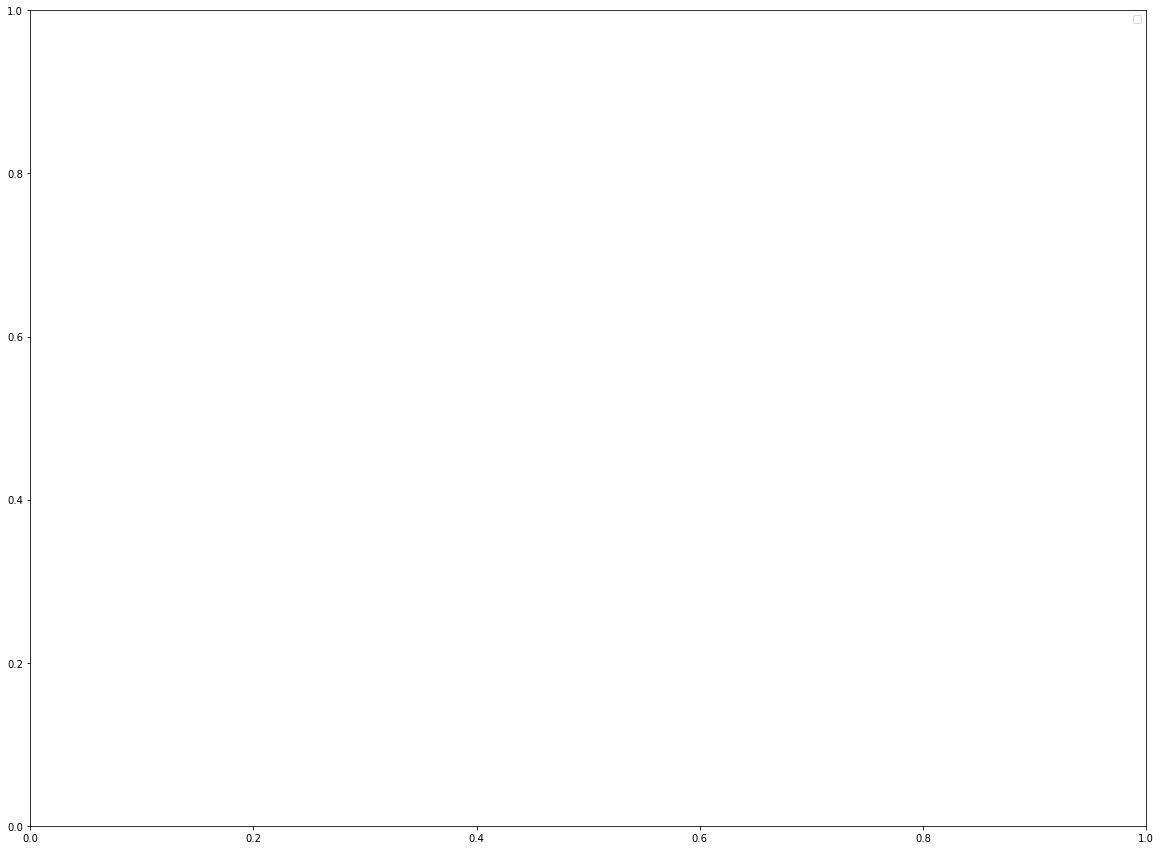

In [ ]:
#Now we plot the changes in the learning rate
fig, axis = plt.subplots(figsize = (20,15))
epoch_line = np.arange(1, 3000, 10)#the number of epochs

for element in changes_loss:
    plt.plot(epoch_line, changes_loss[i], label=str(element))

plt.legend()
plt.show()

In [ ]:
#Lets try our experiment once more with another learninng rate values
changes_loss = {}
lrate = [0.001, 0.003, 0.005, 0.007,0.009]

for lr in learning_rate_plot:
    print ('Trainig model with hidden size {}, number of layers {}, learning rate {}'.format(128, 2, lr))
    
    trained_model, loss = parameters_tuning(hidden_size=128, n_layers=2, lr=lr) 
    print ('Minimal loss ', min(loss))
    changes_loss[lr] = loss

Here we can see that the change is not very big.So,we can keep 0,01 as a learning rate.